In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def draw_mus(a, b, num):
    mus1 = np.random.lognormal(a, size=num)
    #mus2 = np.random.lognormal(sigma=b, size=num)
    #mus1 = np.random.exponential(a, size=num)
    mus2 = np.random.exponential(b, size=num)
    return mus1, mus2

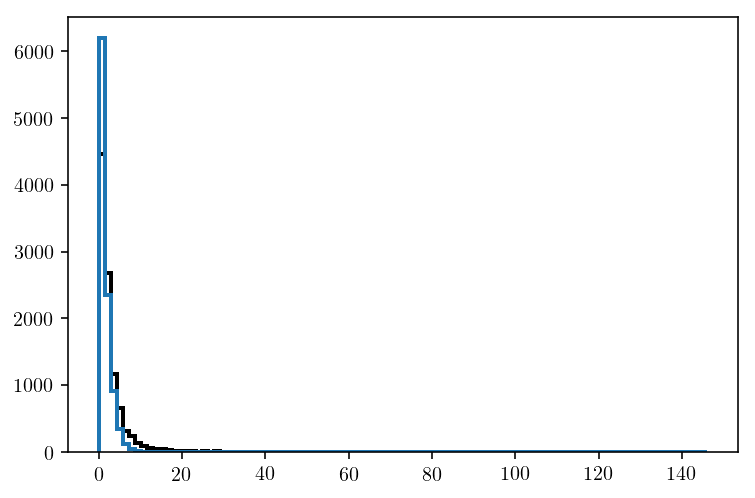

In [40]:
a = .5
b = 1.5
num = 10000
mus1, mus2 = draw_mus(a, b, num)

nbins = 100
maxval = np.max([mus1, mus2]) /
plt.hist(mus1, nbins, histtype='step', range=[0, maxval])
plt.hist(mus2, nbins, histtype='step', range=[0, maxval]);

In [41]:
def compute_evidences(mus1, mus2, nbins):
    evidence1 = np.sum(mus1 > mus2) / float(mus1.size)
    evidence2 = 1 - evidence1
    return evidence1, evidence2

In [42]:
compute_evidences(mus1, mus2, nbins)

(0.65000000000000002, 0.34999999999999998)

In [6]:
num = 1000
nbins = 50
a_vals, b_vals = np.mgrid[0:3:100j, 0:3:100j]
evidences1 = np.zeros_like(a_vals).ravel()
for i, (a, b) in enumerate(zip(a_vals.ravel(), b_vals.ravel())):
    mus1, mus2 = draw_mus(a, b, num)
    evidences1[i] = compute_evidences(mus1, mus2, nbins)[0]
evidences1 = evidences1.reshape(a_vals.shape)

Text(0,0.5,'b')

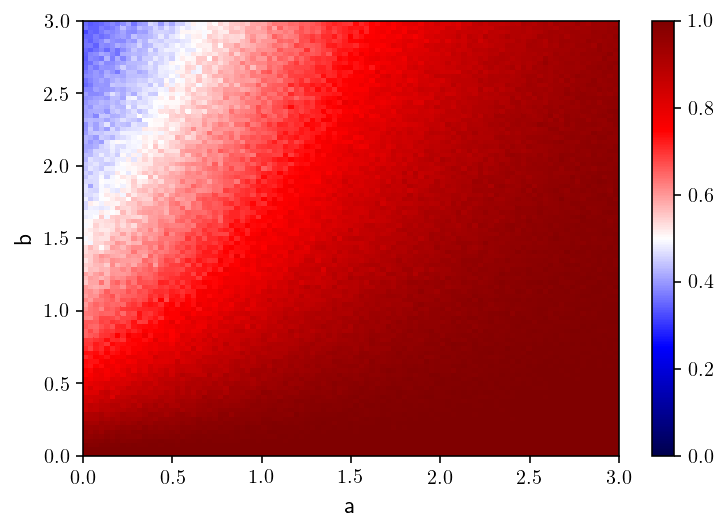

In [7]:
fig, ax = plt.subplots(1, 1)
v = ax.pcolormesh(a_vals, b_vals, evidences1, cmap='seismic', vmin=0, vmax=1)
fig.colorbar(v)
ax.set_xlabel('a')
ax.set_ylabel('b')

In [11]:
num = 10000
a_vals = np.random.uniform(0, 3, num)
b_vals = np.random.uniform(0, 3, num)
evidences1 = np.zeros_like(a_vals)
for i, (a, b) in enumerate(zip(a_vals.ravel(), b_vals.ravel())):
    mus1, mus2 = draw_mus(a, b, num)
    evidences1[i] = compute_evidences(mus1, mus2, nbins)[0]

Text(0.5,1,'Epsilon = 0.010000')

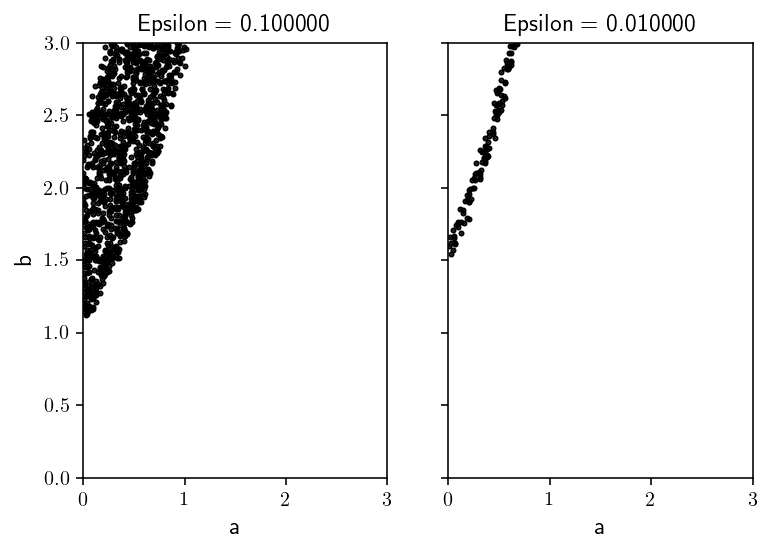

In [12]:

epsilon1, epsilon2 = 0.1, 0.01
ind1 = np.abs(evidences1 - 0.5) < epsilon1
ind2 = np.abs(evidences1 - 0.5) < epsilon2

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].scatter(a_vals[ind1], b_vals[ind1], s=1)
axs[1].scatter(a_vals[ind2], b_vals[ind2], s=1)
axs[0].set_xlim([0, 3])
axs[0].set_ylim([0, 3])
axs[0].set_xlabel('a')
axs[1].set_xlabel('a')
axs[0].set_ylabel('b')
axs[0].set_title('Epsilon = %f' % epsilon1)
axs[1].set_title('Epsilon = %f' % epsilon2)

In [13]:
# https://github.com/rcmorehead/simpleabc
# https://github.com/rcmorehead/simpleabc/blob/master/SimpleABC_demo.ipynb
from simple_abc import Model, basic_abc, pmc_abc

In [20]:
class MyModel(Model):
    
    #This method initializes the model object. In this case it does nothing, but you can have you model 
    #do something when the model object is created, like read in a table of something. 
    def __init__(self):
        pass
    
    #This is the method that draws from you prior. In this example it draws from frozen scipy.stats 
    #distributions that are set with the Model.set_priors method.
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta
    
    #The method that generates the synthetic data sets.
    def generate_data(self, theta):
        mus1, mus2 = draw_mus(np.max([1e-2, theta[0]]), np.max([1e-2, theta[1]]), 2000)
        evidence1, evidence2 = compute_evidences(mus1, mus2, 50)
        return evidence1
    
    #The method that computes your summary statistics, for a Gaussian we just need mu and sigma
    def summary_stats(self, data):
        return data
    
    #And finally the distance function. We are just going to use the euclidean distance 
    #from our observed summary stats
    def distance_function(self, data, synth_data):
        return np.abs(data - synth_data)

In [21]:
#Set a random seed 
np.random.seed(914)

#We need some real values so we know it is working. 
theta_0 = [0.5, 1.5]

#Initialize our model object
model = MyModel()

#Make our "observed" data. Let's use the model's generate_data method.
data = model.generate_data(theta_0)

#Now we need to set the prior distributions. We were clever and set up our draw theta method to call 
#frozen scipy.stats objects, so we jest need to give the model our prior distributions 
model.set_prior([stats.uniform(loc=0, scale=3), stats.uniform(loc=0, scale=3)])

#And while we are at it, we will give the model our observed data as well
model.set_data(0.5)

In [38]:
# posterior = basic_abc(model, data, min_samples=100, epsilon=0.5)
pmc_posterior = pmc_abc(model, data, epsilon_0=0.5, min_samples=1000, steps=20)

Starting step 0
Starting step 1
Starting step 2
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 7
Starting step 8
Starting step 9
Starting step 10
Starting step 11
Starting step 12
Starting step 13
Starting step 14
Starting step 15
Starting step 16
Starting step 17
Starting step 18
Starting step 19


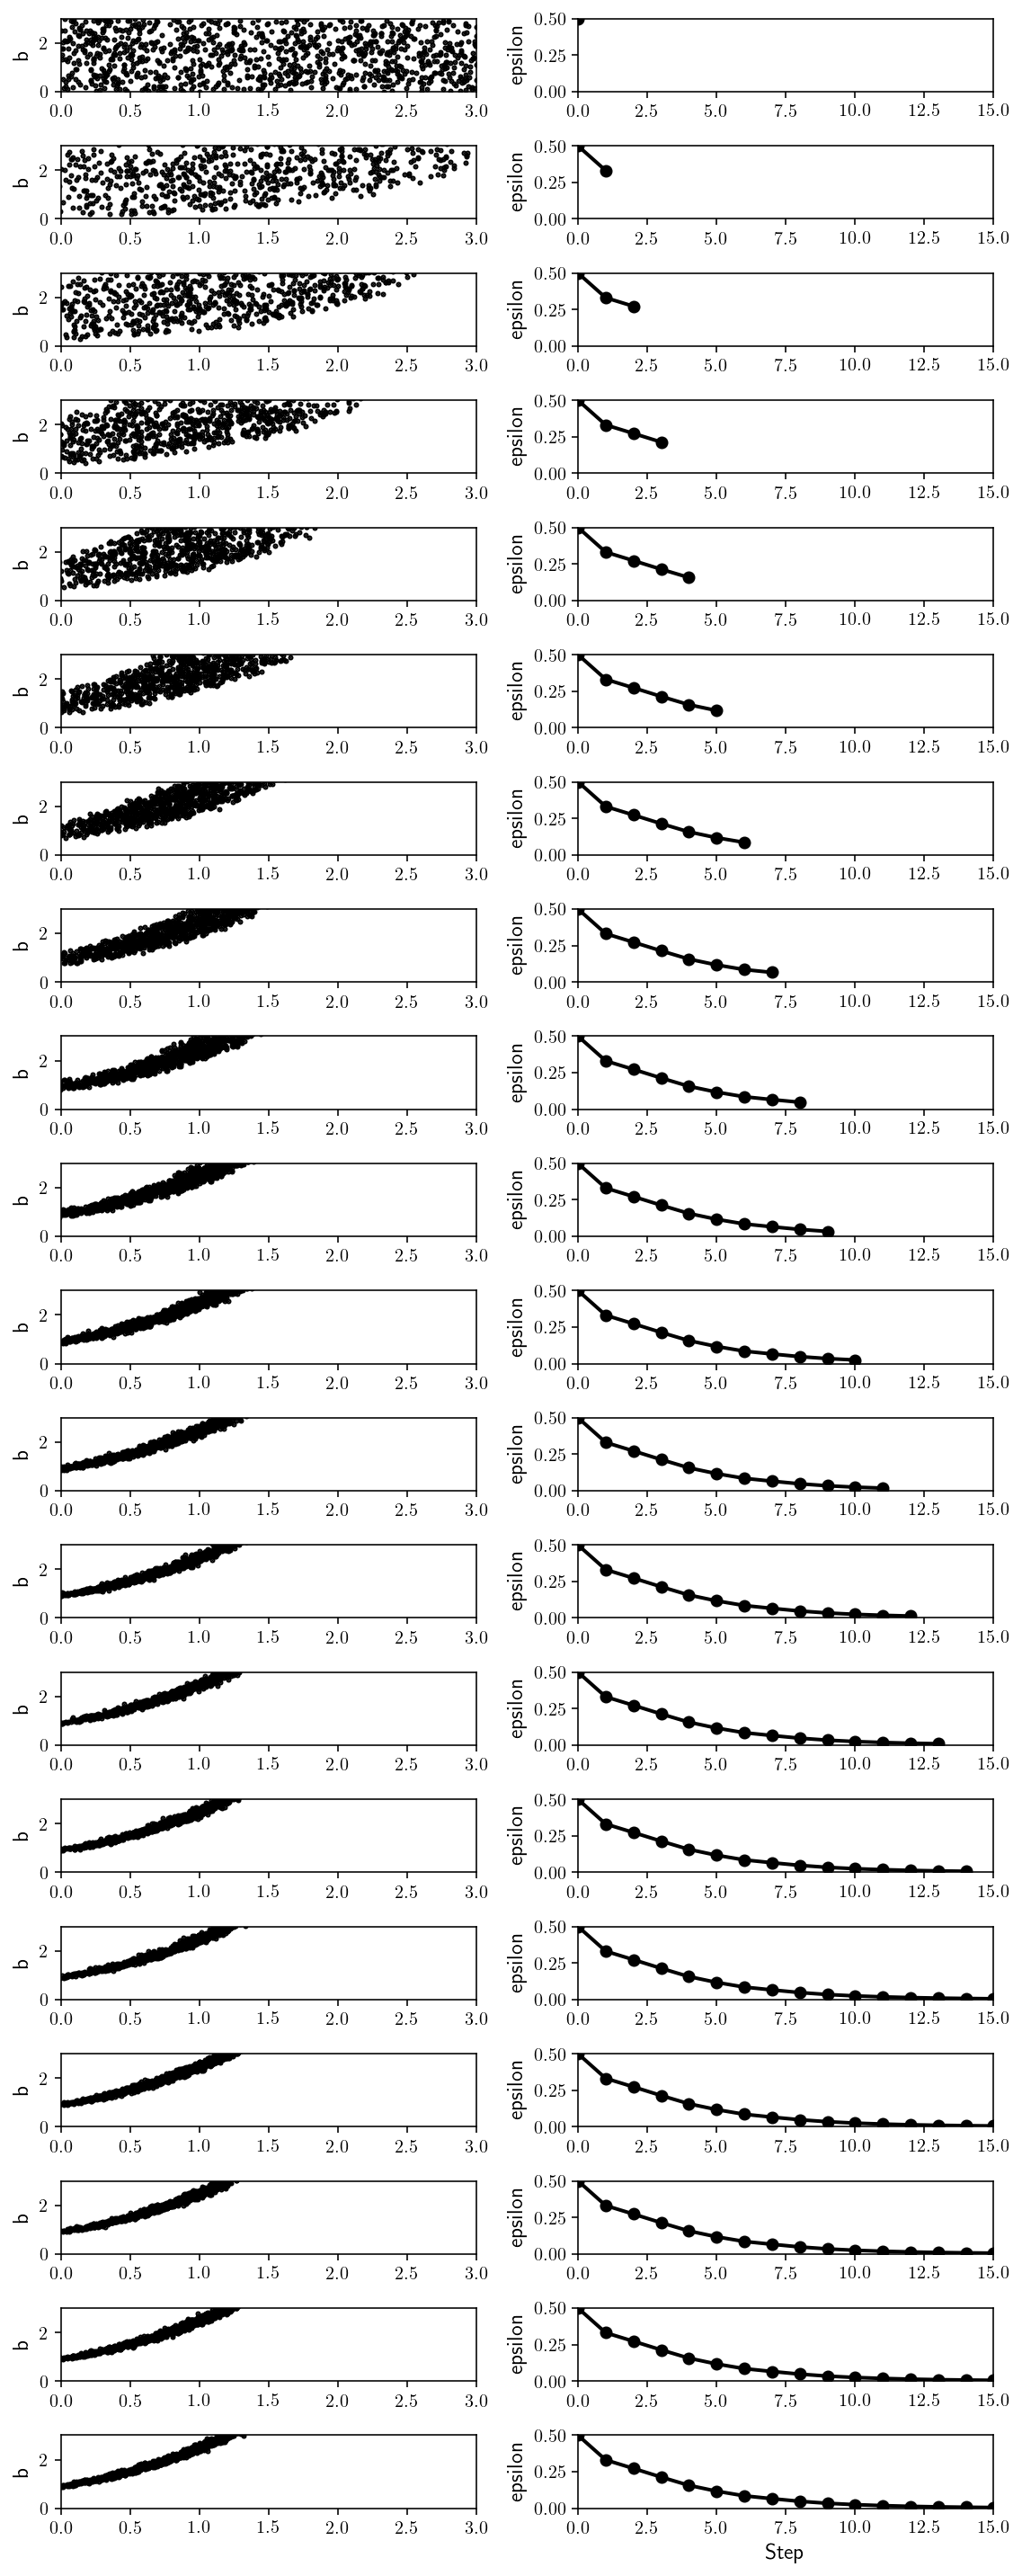

In [39]:
fig, axs = plt.subplots(len(pmc_posterior), 2, figsize=(8, 20), sharex=False, sharey=False)
eps = []
for ip, posterior in enumerate(pmc_posterior):
    eps.append(posterior['epsilon'])
    axs[ip, 0].scatter(posterior[0][0, :], posterior[0][1, :], s=1)    
    axs[ip, 0].set_ylabel('b')
    axs[ip, 0].set_xlim([0, 3])
    axs[ip, 0].set_ylim([0, 3])

    axs[ip, 1].plot(eps,'-o')
    axs[ip, 1].set_ylabel('epsilon')
    axs[ip, 1].set_xlim(0,15)
    axs[ip, 1].set_ylim(0, 0.5)
axs[-1, 1].set_xlabel('a')
axs[-1, 1].set_xlabel('Step')
fig.tight_layout()

In [ ]:
# posterior = basic_abc(model, data, min_samples=100, epsilon=0.5)
pmc_posterior = pmc_abc(model, data, epsilon_0=0.1, min_samples=50, steps=30)

Starting step 0
Starting step 1
Starting step 2
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 7
Starting step 8
Starting step 9
Starting step 10
Starting step 11
Starting step 12
Starting step 13
Starting step 14
Starting step 15
Starting step 16
Starting step 17


In [ ]:
fig, axs = plt.subplots(len(pmc_posterior), 2, figsize=(8, 20), sharex=False, sharey=False)
eps = []
for ip, posterior in enumerate(pmc_posterior):
    eps.append(posterior['epsilon'])
    axs[ip, 0].scatter(posterior[0][0, :], posterior[0][1, :], s=1)    
    axs[ip, 0].set_ylabel('b')
    axs[ip, 0].set_xlim([0, 3])
    axs[ip, 0].set_ylim([0, 3])

    axs[ip, 1].plot(eps,'-o')
    axs[ip, 1].set_ylabel('epsilon')
    axs[ip, 1].set_xlim(0,15)
    axs[ip, 1].set_ylim(0, 0.5)
axs[-1, 1].set_xlabel('a')
axs[-1, 1].set_xlabel('Step')
fig.tight_layout()